In [1]:
from sklearn.datasets import make_blobs, make_moons
import numpy as np
import pandas
import random
import matplotlib.pyplot as plt
import matplotlib
from typing import Callable, Union, NoReturn, Optional, Dict, Any, List

### Information Gain

In [2]:
def gini(x: np.ndarray) -> float:
    unique, counts = np.unique(x, return_counts=True)
    p = counts/np.sum(counts) 
    ones = np.ones_like(p)
    return np.sum(p * (ones - p))

    
def entropy(x: np.ndarray) -> float:
    unique, counts = np.unique(x, return_counts=True)
    p = counts/np.sum(counts)
    return -np.sum(p * np.log(p))


def gain(left_y: np.ndarray, right_y: np.ndarray, criterion: Callable) -> float:
    w_l = left_y.shape[0]
    w_r = right_y.shape[0]
    w_total = w_l + w_r
    
    y = np.concatenate((left_y, right_y))

    return w_total * criterion(y) - w_r * criterion(right_y) - w_l * criterion(left_y)

### Decision Tree

In [3]:
class DecisionTreeLeaf():
    def __init__(self, labels):
        unique, counts = np.unique(labels, return_counts=True)
        p = counts/np.sum(counts)
        dct = dict(zip(unique, p))

        self.cl = dct
        self.y = None
        
        max_val = max(dct.values())
        for key in dct:
            if dct[key] == max_val:
                self.y = key
                break

In [4]:
class DecisionTreeNode():     
    def __init__(self, split_dim: int, split_value: float, 
                 left: Union['DecisionTreeNode', DecisionTreeLeaf], 
                 right: Union['DecisionTreeNode', DecisionTreeLeaf]):
                
        self.split_dim = split_dim
        self.split_value = split_value
        self.left = left
        self.right = right

In [5]:
class DecisionTreeClassifier:
    def __init__(self, criterion : str = "gini", 
                 max_depth : Optional[int] = None, 
                 min_samples_leaf: int = 1):    
        if criterion != 'gini' and criterion != 'entropy':
            raise ValueError('Unknown criterion')
        self.root = None
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
       
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> NoReturn:  
        self.root = self.build(X, y)
        
    
    def build(self, X: np.ndarray, y: np.ndarray, curr_depth=0):
        if curr_depth == self.max_depth or len(np.unique(y)) == 1 or len(y) < 2*self.min_samples_leaf:
            step = DecisionTreeLeaf(y)
    
        else:
            IG = 0
            curr_dim = None
            curr_value = None
            max_left = None
            max_right = None
            
            for dim in range(X.shape[1]):
                values = np.unique(X[:,dim])
                for value in values:   
                    
                    left = np.where(X[:,dim] <= value)
                    right = np.where(X[:,dim] > value)
                    
                    if min(y[left].shape[0], y[right].shape[0]) < self.min_samples_leaf:
                        continue
                                                   
                    new_IG = gain(y[left], y[right], gini) if self.criterion=='gini' else gain(y[left], y[right], entropy)
                    
                    if new_IG > IG: 
                        IG = new_IG
                        curr_dim = dim
                        curr_value = value
                        max_left = left
                        max_right = right
                                        
            if IG == 0:
                step = DecisionTreeLeaf(y)
                
            else:
                curr_depth += 1
                left_node = self.build(X[max_left], y[max_left], curr_depth)
                right_node = self.build(X[max_right], y[max_right], curr_depth)
                step = DecisionTreeNode(curr_dim, curr_value, left_node, right_node)
            
        return step
    
    
    def predict_proba(self, X: np.ndarray) ->  List[Dict[Any, float]]:             
        n = X.shape[0]
        indices = np.linspace(0, n-1, n, dtype=int).reshape(n, 1)
        
        X_ = np.copy(X)
        data = np.concatenate((X_, indices), axis=1)
        curr_node = self.root
        
        new_array = self.func(data, curr_node)
        sorted_array = new_array[new_array[:,0].argsort()]
        
        return sorted_array[:,1]
        
        
    def func(self, data, curr_node):
        
        if isinstance(curr_node, DecisionTreeLeaf):
            dicts = np.array([curr_node.cl for i in range(data.shape[0])])
            indices = data[:,-1]           
            return np.stack((indices, dicts)).T
        
        else:
            left_node = curr_node.left
            left_part = data[data[:,curr_node.split_dim] <= curr_node.split_value]
            
            right_node = curr_node.right
            right_part = data[data[:,curr_node.split_dim] > curr_node.split_value]
    
            return np.concatenate((self.func(left_part, left_node), self.func(right_part, right_node)))
            
        
    def predict(self, X : np.ndarray) -> list:
        proba = self.predict_proba(X)
        return [max(p.keys(), key=lambda k: p[k]) for p in proba]

### Визуализация построенного дерева

In [6]:
def tree_depth(tree_root):
    if isinstance(tree_root, DecisionTreeNode):
        return max(tree_depth(tree_root.left), tree_depth(tree_root.right)) + 1
    else:
        return 1

def draw_tree_rec(tree_root, x_left, x_right, y):
    x_center = (x_right - x_left) / 2 + x_left
    if isinstance(tree_root, DecisionTreeNode):
        x_center = (x_right - x_left) / 2 + x_left
        x = draw_tree_rec(tree_root.left, x_left, x_center, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        x = draw_tree_rec(tree_root.right, x_center, x_right, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        plt.text(x_center, y, "x[%i] < %f" % (tree_root.split_dim, tree_root.split_value),
                horizontalalignment='center')
    else:
        plt.text(x_center, y, str(tree_root.y),
                horizontalalignment='center')
    return x_center

def draw_tree(tree, save_path=None):
    td = tree_depth(tree.root)
    plt.figure(figsize=(0.33 * 2 ** td, 2 * td))
    plt.xlim(-1, 1)
    plt.ylim(0.95, td + 0.05)
    plt.axis('off')
    draw_tree_rec(tree.root, -1, 1, td)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

In [7]:
def plot_roc_curve(y_test, p_pred):
    positive_samples = sum(1 for y in y_test if y == 0)
    tpr = []
    fpr = []
    for w in np.arange(-0.01, 1.02, 0.01):
        y_pred = [(0 if p.get(0, 0) > w else 1) for p in p_pred]
        tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
        fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
    plt.figure(figsize = (7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

def rectangle_bounds(bounds):
    return ((bounds[0][0], bounds[0][0], bounds[0][1], bounds[0][1]), 
            (bounds[1][0], bounds[1][1], bounds[1][1], bounds[1][0]))

def plot_2d_tree(tree_root, bounds, colors):
    if isinstance(tree_root, DecisionTreeNode):
        if tree_root.split_dim:
            plot_2d_tree(tree_root.left, [bounds[0], [bounds[1][0], tree_root.split_value]], colors)
            plot_2d_tree(tree_root.right, [bounds[0], [tree_root.split_value, bounds[1][1]]], colors)
            plt.plot(bounds[0], (tree_root.split_value, tree_root.split_value), c=(0, 0, 0))
        else:
            plot_2d_tree(tree_root.left, [[bounds[0][0], tree_root.split_value], bounds[1]], colors)
            plot_2d_tree(tree_root.right, [[tree_root.split_value, bounds[0][1]], bounds[1]], colors)
            plt.plot((tree_root.split_value, tree_root.split_value), bounds[1], c=(0, 0, 0))
    else:
        x, y = rectangle_bounds(bounds)
        plt.fill(x, y, c=colors[tree_root.y] + [0.2])

def plot_2d(tree, X, y):
    plt.figure(figsize=(9, 9))
    colors = dict((c, list(np.random.random(3))) for c in np.unique(y))
    bounds = list(zip(np.min(X, axis=0), np.max(X, axis=0)))
    plt.xlim(*bounds[0])
    plt.ylim(*bounds[1])
    plot_2d_tree(tree.root, list(zip(np.min(X, axis=0), np.max(X, axis=0))), colors)
    for c in np.unique(y):
        plt.scatter(X[y==c, 0], X[y==c, 1], c=[colors[c]], label=c)
    plt.legend()
    plt.tight_layout()
    plt.show()

### Проверка на синтетических данных

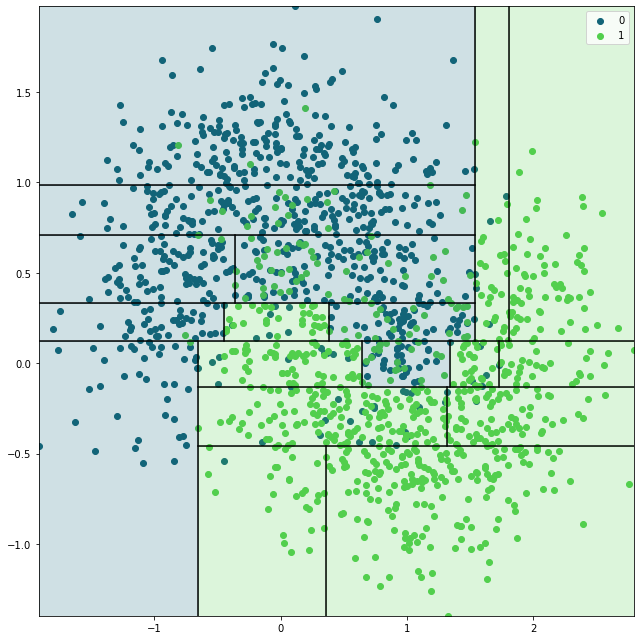

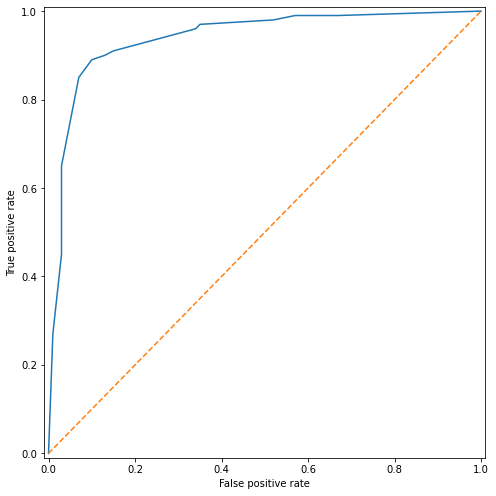

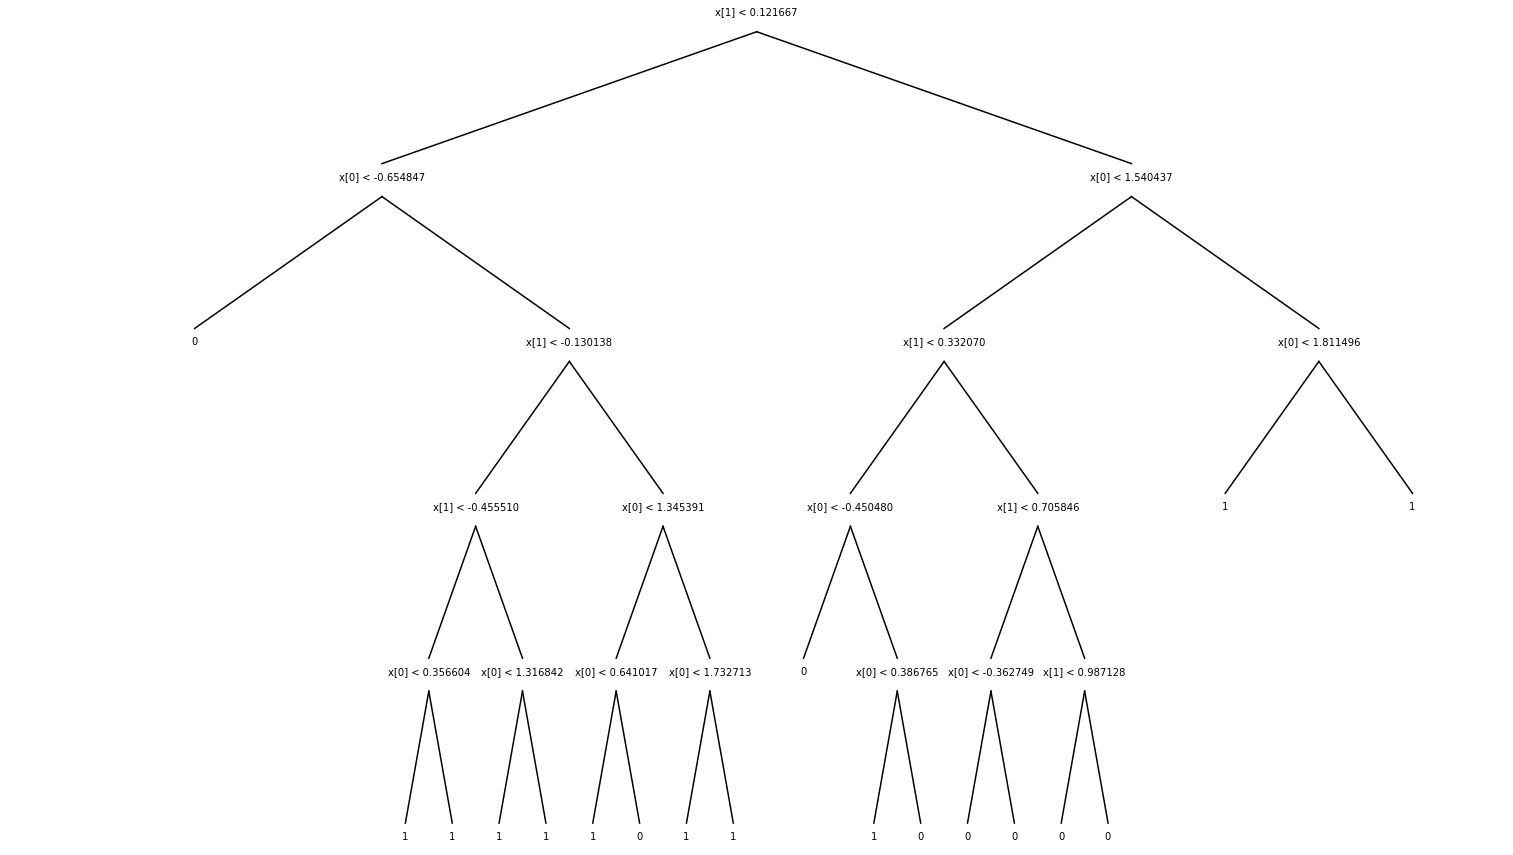

In [8]:
noise = 0.35
X, y = make_moons(1500, noise=noise)
X_test, y_test = make_moons(200, noise=noise)
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
tree.fit(X, y)
plot_2d(tree, X, y)
plot_roc_curve(y_test, tree.predict_proba(X_test))
draw_tree(tree)

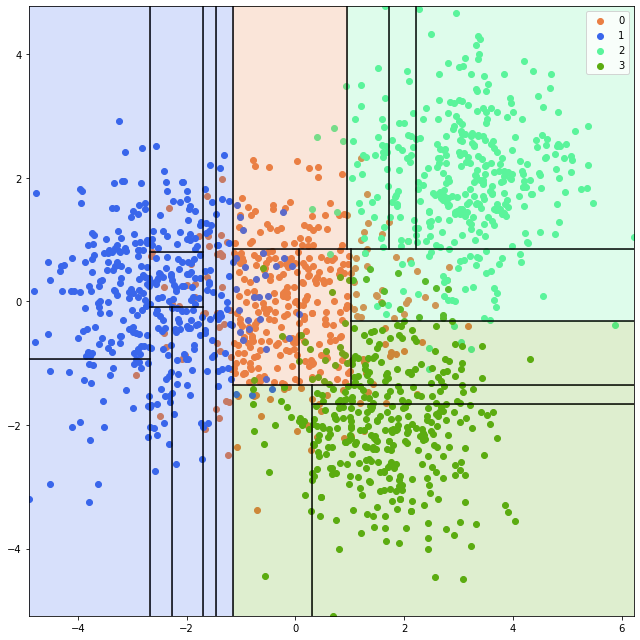

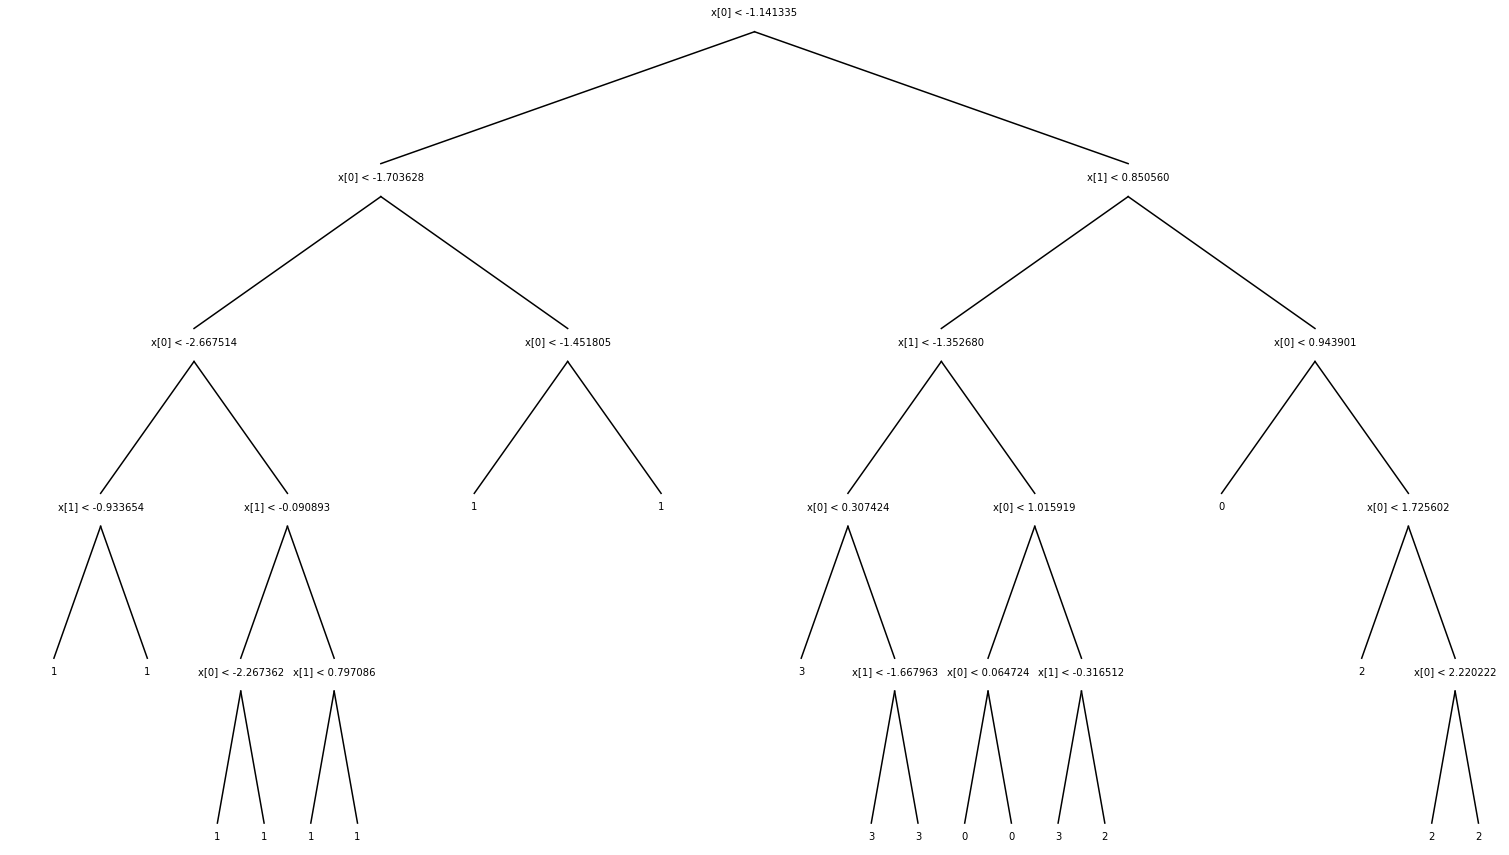

In [9]:
X, y = make_blobs(1500, 2, centers=[[0, 0], [-2.5, 0], [3, 2], [1.5, -2.0]])
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
tree.fit(X, y)
plot_2d(tree, X, y)
draw_tree(tree)

 ### Проверка на датасете train.csv

In [10]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [11]:
def read_dataset(path):
    dataframe = pandas.read_csv(path, header=1)
    dataset = dataframe.values.tolist()
    random.shuffle(dataset)
    y = [row[0] for row in dataset]
    X = [row[1:] for row in dataset]
    return np.array(X), np.array(y)

In [12]:
X, y = read_dataset("train.csv")
X, X_val, y, y_val = train_test_split(X, y, train_size=0.9, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

num = 5
scores = np.zeros(num)
hyperparams = np.array([5**i for i in range(num)])

for i in range(num):    
    dtc = DecisionTreeClassifier(max_depth=6, min_samples_leaf=hyperparams[i])
    dtc.fit(X_train, y_train)    
    y_pred = dtc.predict(X_val)
    y_true = y_val
    scores[i] = accuracy_score(y_true, y_pred)
    
print('hyperparams_scores =', scores)

best = hyperparams[np.argmax(scores)]
dtc = DecisionTreeClassifier(max_depth=6, min_samples_leaf=best)
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
y_true = y_test
print('result =', accuracy_score(y_true, y_pred))

hyperparams_scores = [0.93333333 0.91666667 0.83333333 0.73333333 0.25      ]
result = 0.9629629629629629


### Predict_explain

In [13]:
def predict_explain(dtc: DecisionTreeClassifier, X: np.ndarray):
    
    features = pandas.read_csv("train.csv", nrows=0).columns.tolist()[1:]    
    elements = X.shape[0]
    depth = dtc.max_depth
        
    pred = dtc.predict(X)
    explain = np.zeros((elements, depth+1, 1), dtype=object) 

    for i, x in enumerate(X):    
        curr_node = dtc.root
        count = 0
        while isinstance(curr_node, DecisionTreeNode):

            part1 = features[curr_node.split_dim] + ' '*(30 - len(features[curr_node.split_dim]))
            part2 = 'threshold: ' + str(curr_node.split_value)
            part3 = ' '*(65 - len(part1) - len(part2)) + 'x_value: ' + str(x[curr_node.split_dim])
            
            explain[i][count + 1] = part1 + part2 + part3
            count += 1
    
            if x[curr_node.split_dim] <= curr_node.split_value:
                curr_node = curr_node.left
            else:
                curr_node = curr_node.right    

    explain[explain==[0]] = '(^_^)'           
    
    return zip(pred, explain)

In [14]:
X, y = read_dataset("train.csv")
for pred_y, expl in predict_explain(dtc, X[:20]):
    print("Class:", pred_y)
    print("Explanation:", expl)
    print()

Class: cleric
Explanation: [['(^_^)']
 ['death in pvp percentage       threshold: 0.3378234527577652      x_value: 0.2928138857870634']
 ['player kills per death        threshold: 0.6569466005586547      x_value: 0.3301803219535352']
 ['monster kills per death       threshold: 2.122461138395303       x_value: 0.1591882919675417']
 ['player kills per death        threshold: 0.4871082342552439      x_value: 0.3301803219535352']
 ['death in pvp percentage       threshold: 0.330242605286813       x_value: 0.2928138857870634']
 ['player kills per death        threshold: 0.3879368541001024      x_value: 0.3301803219535352']]

Class: rogue
Explanation: [['(^_^)']
 ['death in pvp percentage       threshold: 0.3378234527577652      x_value: 0.0052621659943778']
 ['player kills per death        threshold: 0.6569466005586547      x_value: 1.4127458206828252']
 ['accuracy                      threshold: 0.4057840625558155      x_value: 0.47293403357011']
 ['player kills per death        threshold: